## Medical Image Segmentation using Lung CT NIfTI Files

Medical image segmentation is a critical task in medical imaging, aiming to partition images into meaningful regions, such as separating organs or identifying pathologies. This process is essential for various clinical and research applications, enabling accurate analysis and treatment planning. In this tutorial, we will focus on segmenting lung structures from CT scans using traditional image processing methods.

#### Objectives
- Understand the concept of medical image segmentation.
- Explore different types of segmentation techniques.
- Assess segmentation using appropriate metrics.



### What is Image Segmentation?
Image segmentation involves partitioning an image into distinct regions based on specific criteria, such as intensity values, edges, or texture. The goal is to label each pixel in the image with a class (e.g., lung, background) to highlight structures of interest.

Medical image segmentation is crucial for:
1. **Diagnosis**: Segmenting organs or tumors helps in identifying abnormalities and aids in diagnosis.
2. **Treatment Planning**: Accurate segmentation ensures precise targeting of treatment areas, such as in radiation therapy.
3. **Surgical Planning**: Segmentation guides surgical procedures by identifying anatomical structures, ensuring safer surgeries.
4. **Disease Monitoring**: Longitudinal segmentation helps track disease progression or treatment response by quantifying changes in tissue volume.
5. **Research**: Provides standardized measurements and regions of interest for further analysis, particularly in clinical trials and population-based studies.

In medical imaging, segmentation typically deals with organs (e.g., lungs, liver), tissues (e.g., muscles, fat), or pathological regions (e.g., tumors).

### Types of Segmentation Methods

In medical image segmentation, different types of segmentation methods can be used, each with specific advantages and disadvantages depending on the imaging modality (e.g., MRI, CT, ultrasound) and the anatomical structures of interest. Here's a breakdown of the types of segmentation techniques that are commonly applied in medical image analysis:

| **Segmentation Type**       | **Description**                                                                 | **Example Use Cases**                                         |
|-----------------------------|---------------------------------------------------------------------------------|---------------------------------------------------------------|
| Threshold-Based            | Separates regions based on intensity values. Simple and fast.                    | Bone segmentation in CT, lung extraction                      |
| Region-Based               | Expands regions from seed points based on similarity criteria like intensity.     | Tumor delineation, liver segmentation                          |
| Edge-Based                 | Detects boundaries by identifying significant changes in intensity.               | Organ contour extraction, tumor boundaries                     |
| Clustering-Based           | Groups pixels into clusters based on similarity, suitable for multi-modal data.  | Brain tissue segmentation, tissue differentiation              |
| Graph-Based                | Uses graphs to find globally optimal segmentations based on similarity measures.  | Blood vessel segmentation, brain tumor segmentation            |
| Morphological              | Uses operations like dilation, erosion, opening, and closing to refine results.  | Noise removal, refining lung masks                             |
| Atlas-Based                | Uses a reference template or atlas for guiding segmentation.                     | Brain atlas registration, organ segmentation in pediatrics     |
| Texture-Based              | Analyzes texture patterns for segmentation, capturing fine details.               | Tumor heterogeneity analysis, tissue characterization          |
| Statistical Shape Models   | Uses shape models built from training data to segment predictable structures.     | Prostate segmentation, heart modeling                          |
| Level Set                  | Evolves curves over time to segment based on energy minimization principles.     | Complex tumor segmentation, 3D organ separation                |

Each of these segmentation methods has strengths and is chosen based on the problem, image quality, and anatomical structures involved. Understanding the data's nature and the anatomy to be segmented aids in selecting the most appropriate method.

In [3]:
# Import necessary libraries
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology, measure, filters, feature
from skimage.segmentation import watershed, random_walker, morphological_geodesic_active_contour
from skimage.feature import canny, local_binary_pattern
from skimage.morphology import disk
import os
import glob

In [4]:
# Load the Lung CT slices
input_folder = "Lung_Images/"
file_paths = sorted(glob.glob(os.path.join(input_folder, "*.nii.gz")))

# Function to resize slices to a common shape
def resize_to_shape(data, target_shape):
    return ndi.zoom(data, np.array(target_shape) / np.array(data.shape), order=1)

# Determine the target shape (use the shape of the first slice as reference)
reference_shape = nib.load(file_paths[0]).get_fdata().shape

# Combine all slices into a 3D array with uniform shape
lung_slices = []
for fp in file_paths:
    slice_data = nib.load(fp).get_fdata()
    if slice_data.shape != reference_shape:
        slice_data = resize_to_shape(slice_data, reference_shape)
    lung_slices.append(slice_data)

# Stack resized slices into a 3D volume
lung_volume = np.stack(lung_slices, axis=-1)
print(f"Lung volume shape: {lung_volume.shape}")


Lung volume shape: (512, 512, 21)


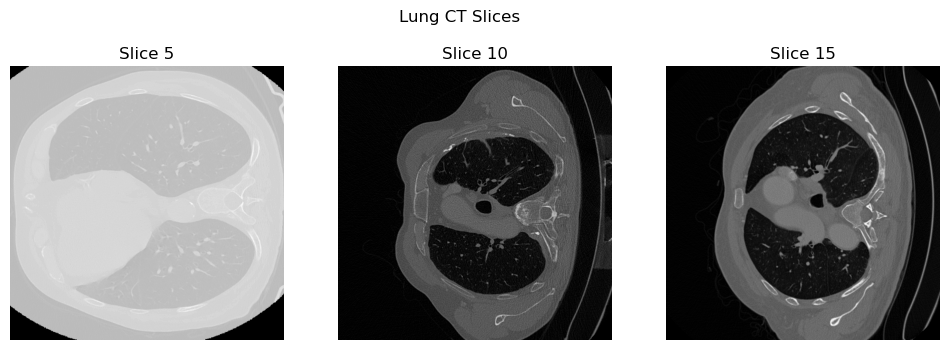

In [5]:
# Visualize function
def plot_slices(volume, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [5, 10, 15]  # Adjust based on volume size
    for ax, slice_idx in zip(axes, mid_slices):
        ax.imshow(volume[:, :, slice_idx], cmap='gray')
        ax.set_title(f'Slice {slice_idx}')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Visualize the lung volume
plot_slices(lung_volume, title="Lung CT Slices")


#### Hounsfield  Vaules and Windowing

CT images store pixel values that represent the radiodensity of tissues. These raw values need to be converted to Hounsfield Units (HU), which provide a standardized scale of tissue density. The conversion depends on metadata parameters stored in the CT image: the *rescale slope* and *intercept*.

Additionally, in cases where the scan's output is square but the actual scan region is cylindrical (as is often the case), certain pixels in the image will lie outside the cylindrical bounds. These pixels are typically assigned a value of `-2000`, indicating regions outside the scan (non-imaged areas). For proper processing, these values should be set to `0`, which corresponds to air.


##### HU Conversion Formula:
$$
\text{HU} = \text{Pixel Value} \times \text{Rescale Slope} + \text{Intercept}
$$


### HU Values and Common Windowing Ranges for Segmentation

| **Substance/Tissue**      | **Typical HU Range**                 | **Common Windowing**                     | **Segmentation Methods**                                      |
|---------------------------|---------------------------------------|-------------------------------------------|---------------------------------------------------------------|
| **Air**                   | -1000                                 | `[-1000, -800]` for air-filled structures | Thresholding for lung parenchyma, segmentation of cavities    |
| **Lung**                  | -500                                  | `[-1000, -400]`                           | Thresholding, region-based (watershed), edge-based            |
| **Fat**                   | -100 to -50                           | `[-100, +200]`                            | Region-based, texture-based                                  |
| **Water**                 | 0                                     | `[-100, +200]`                            | General reference point, often used in contrast studies      |
| **CSF (Cerebrospinal Fluid)** | 15                               | `[-50, +100]`                             | Brain segmentation, intensity-based registration              |
| **Kidney**                | 30                                    | `[+30, +90]`                              | Graph-based segmentation, region growing                      |
| **Blood**                 | +30 to +45                            | `[+30, +90]`                              | Region-based methods, graph-based segmentation                |
| **Muscle**                | +10 to +40                            | `[-100, +200]`                            | Region-based, texture-based, graph-based                      |
| **Grey matter**           | +37 to +45                            | `[-50, +100]`                             | Brain segmentation, intensity-based registration              |
| **White matter**          | +20 to +30                            | `[-50, +100]`                             | Brain segmentation, region-based                              |
| **Liver**                 | +40 to +60                            | `[+30, +90]`                              | Graph-based segmentation (e.g., random walker), texture-based |
| **Soft Tissue, Contrast** | +100 to +300                          | `[-100, +200]`                            | Region-based, graph-based, texture-based                      |
| **Bone**                  | +700 (cancellous) to +3000 (cortical) | `[-300, +2000]`                           | Thresholding for bone extraction, statistical shape models    |




### Why Windowing Ranges Are Useful

1. **Focus on Specific Tissues**:
   - Different anatomical structures have specific HU ranges. For example:
     - **Lung tissues**: typically fall between `-1000` and `-400` HU.
     - **Soft tissues**: such as muscles or organs like the liver, have HU values around `-100` to `+200`.
     - **Bone**: values are higher, ranging from `+300` to `+2000` HU.
   - Applying windowing helps focus on the intensity ranges that best represent the tissue of interest, making segmentation more accurate.

2. **Enhancing Contrast for Specific Methods**:
   - Segmentation methods like thresholding, edge detection, and even some region-based methods work better when there is good contrast between the region of interest and the background. Proper windowing enhances this contrast.

3. **Reducing Noise and Artifacts**:
   - Windowing can help suppress irrelevant structures and noise. For example, a narrow window focusing on lung tissue can ignore the high-density bones, making it easier to isolate the lungs.

### 1. Threshold-Based Segmentation

Threshold-based segmentation is a simple and effective technique used to separate objects from the background in an image by converting grayscale or intensity images into binary images. This method involves selecting a specific intensity value (or range) as a threshold to distinguish between different regions.

- **Key Features**:
  - **Intensity Values**: Pixels with intensity values above the threshold are classified as one class (e.g., object), while those below are classified as another (e.g., background). 
  - **Applications**: Commonly used in various fields, such as medical imaging for tumor detection, industrial applications for quality control, and computer vision for object detection.

The choice of threshold value is crucial; too low may include noise or unwanted objects, while too high may miss important features. The optimal threshold maximizes the distinction between the object and background, often determined through methods like Otsu's method, which computes the threshold that minimizes intra-class variance.

Threshold-based segmentation is particularly useful when the object and background have significantly different intensity distributions, allowing for straightforward and efficient separation.

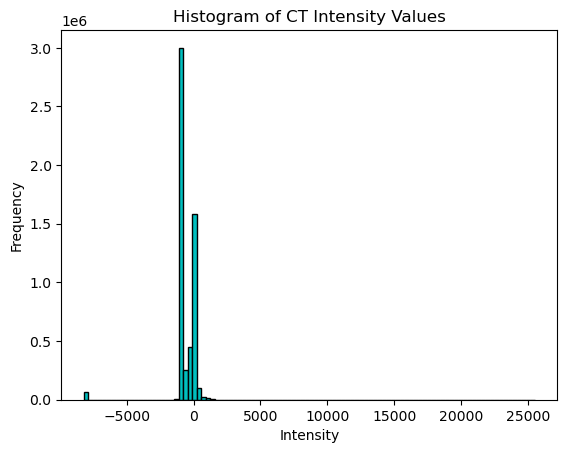

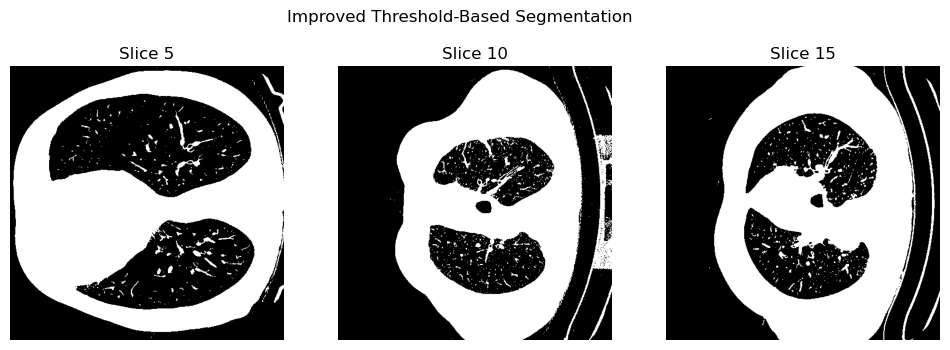

In [7]:
# Plot histogram of intensity values to find suitable threshold ranges
plt.hist(lung_volume.flatten(), bins=100, color='c', edgecolor='black')
plt.title("Histogram of CT Intensity Values")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Apply windowing: focus on typical lung tissue range in Hounsfield Units (HU)
# This range is typically between -1000 and -400 HU for lung tissues.
lung_window = np.clip(lung_volume, -1000, -400)

# Normalize the windowed volume to [0, 1] for better thresholding
normalized_lung_volume = (lung_window - lung_window.min()) / (lung_window.max() - lung_window.min())

# Apply Otsu's thresholding on the normalized volume
from skimage.filters import threshold_otsu
threshold = threshold_otsu(normalized_lung_volume)
binary_volume = normalized_lung_volume > threshold

# Visualize the improved threshold-based segmentation
plot_slices(binary_volume, "Improved Threshold-Based Segmentation")


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure

def plot_3d(image, threshold=-300, title="3D Visualization"):
    verts, faces, _, _ = measure.marching_cubes(image, level=threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, image.shape[0])
    ax.set_ylim(0, image.shape[1])
    ax.set_zlim(0, image.shape[2])
    plt.title(title)
    plt.show()


In [1]:
# Visualize the threshold-based segmentation in 3D
plot_3d(binary_volume, threshold=0.5, title="3D Visualization of Threshold-Based Segmentation")

NameError: name 'plot_3d' is not defined

#### 2. Region-Based Segmentation

Region-Based Segmentation using Watershed is an image segmentation technique that partitions an image into distinct regions based on the intensity of pixels, effectively identifying and delineating objects within an image. This method treats the image as a topographic surface, where regions are formed by simulating the flooding of water from identified markers.

##### Key Features:
- **Topographic Representation**: The algorithm views pixel intensities as elevation levels, with watersheds acting as boundaries that separate different regions.
- **Marker-Based Approach**: Initially, markers are defined within the image (often at the center of objects), and the watershed algorithm expands these markers until they meet the boundaries defined by the intensity gradients.
- **Applications**: Widely used in medical imaging for segmenting organs or tumors, in computer vision for object recognition, and in image processing for identifying connected components.

Region-based segmentation using the watershed algorithm is particularly effective in scenarios where objects are close together and distinct from the background, allowing for precise delineation of boundaries.

In this code, we perform region-based segmentation using the watershed algorithm to identify and separate distinct regions in the image. The segmented result is saved and visualized, demonstrating the effectiveness of the watershed technique in accurately delineating objects based on their intensity gradients.

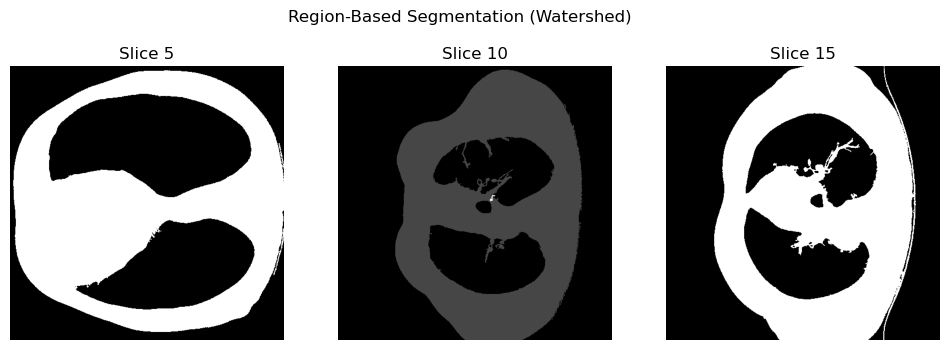

In [8]:
# Apply windowing for better contrast in watershed (-1000 to -400 HU)
lung_window_watershed = np.clip(lung_volume, -1000, -400)
normalized_lung_volume_watershed = (lung_window_watershed - lung_window_watershed.min()) / (
    lung_window_watershed.max() - lung_window_watershed.min())

# Use Canny edge detection as markers for watershed
watershed_volume = np.zeros_like(lung_volume)
for i in range(normalized_lung_volume_watershed.shape[2]):
    edges = canny(normalized_lung_volume_watershed[:, :, i])
    distance = ndi.distance_transform_edt(~edges)
    markers = ndi.label(distance > 5)[0]
    watershed_slice = watershed(-distance, markers, mask=binary_volume[:, :, i])
    watershed_volume[:, :, i] = watershed_slice

# Visualize region-based segmentation
plot_slices(watershed_volume, "Region-Based Segmentation (Watershed)")


#### 3. Edge-Based Segmentation

Edge-Based Segmentation is an image segmentation technique that identifies and delineates objects in an image by detecting sharp changes in intensity, known as edges. This method focuses on locating the boundaries of objects, making it effective for segmenting regions based on their distinct contours.

##### Key Features:
- **Boundary Detection**: Utilizes edge detection operators (e.g., Sobel, Canny, or Prewitt) to find areas where there is a significant gradient in pixel intensity, indicating the presence of an edge.
- **Applications**: Commonly employed in various fields, including medical imaging to identify anatomical structures, in object detection tasks in computer vision, and in industrial applications for quality control.
- **Post-Processing**: Often combined with techniques like morphological operations to refine the detected edges and fill gaps, ensuring more accurate segmentation.

Edge-based segmentation is particularly effective in scenarios where the boundaries of objects are well-defined and distinct from the background, allowing for precise delineation of shapes and contours.

In this code, we perform edge-based segmentation using an edge detection algorithm to identify and outline the boundaries of objects within the image. The segmented result is saved and visualized, showcasing the effectiveness of the edge-based approach in accurately capturing object contours based on intensity changes.



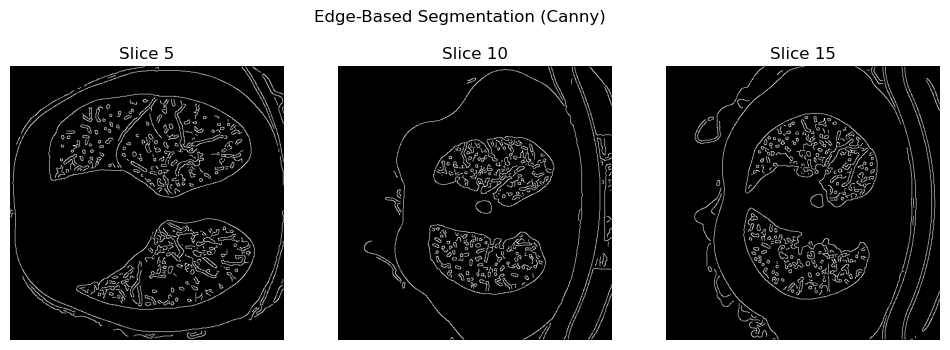

In [9]:
# Windowing to enhance edges (-1000 to -500 HU)
lung_window_edges = np.clip(lung_volume, -1000, -500)
normalized_lung_volume_edges = (lung_window_edges - lung_window_edges.min()) / (
    lung_window_edges.max() - lung_window_edges.min())

# Apply Canny edge detection on each slice
edge_volume = np.zeros_like(normalized_lung_volume_edges)
for i in range(normalized_lung_volume_edges.shape[2]):
    edge_volume[:, :, i] = canny(normalized_lung_volume_edges[:, :, i], sigma=2)

# Visualize edge-based segmentation
plot_slices(edge_volume, "Edge-Based Segmentation (Canny)")


#### 4. Graph-Based Segmentation: Random Walker

Graph-Based Segmentation: Random Walker is an image segmentation technique that models the image as a graph, where pixels are represented as nodes and the edges represent the relationships (or similarities) between them. This method utilizes the concept of random walks to propagate labels through the graph, allowing for effective segmentation based on pixel connectivity.

##### Key Features:
- **Graph Representation**: Each pixel is treated as a node, and edges are defined based on pixel similarity, often calculated using intensity values or spatial proximity.
- **Label Propagation**: The algorithm assigns labels to a subset of pixels (seeds) and then uses random walks to propagate these labels throughout the graph, effectively segmenting the image based on the labels assigned to the seed pixels.
- **Applications**: Commonly used in medical imaging for segmenting organs or tumors, in computer vision for object recognition, and in scenarios where precise boundaries are required, such as separating overlapping objects.

Graph-based segmentation using the Random Walker approach is particularly effective when there are well-defined regions and clear relationships between pixels, as it can accurately capture the connectivity and structure of objects within the image.

In this code, we perform graph-based segmentation using the Random Walker algorithm to partition the image into distinct regions based on pixel relationships. The segmented result is saved and visualized, demonstrating the effectiveness of the Random Walker technique in achieving accurate segmentation through label propagation in a graph framework.

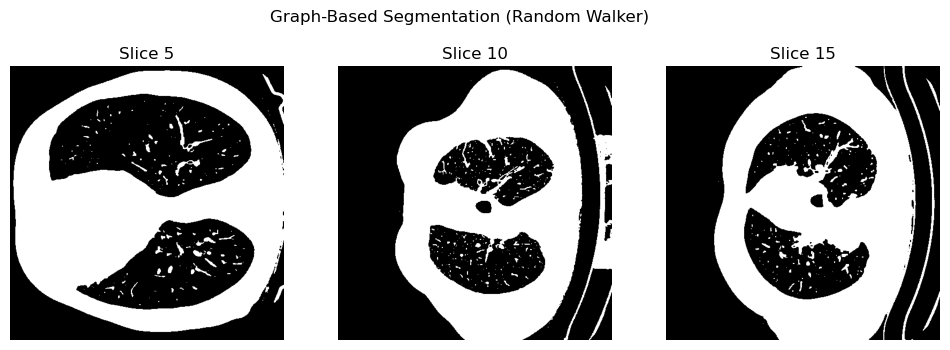

In [10]:
from skimage.segmentation import random_walker

# Step 1: Windowing for soft tissue and air separation for Random Walker (-1000 to -400 HU)
lung_window_graph = np.clip(lung_volume, -1000, -400)
normalized_lung_graph = (lung_window_graph - lung_window_graph.min()) / (
    lung_window_graph.max() - lung_window_graph.min())

# Step 2: Use random walker for graph-based segmentation with adjusted markers
graph_volume = np.zeros_like(normalized_lung_graph)
for i in range(normalized_lung_graph.shape[2]):
    # Create markers based on adjusted thresholds
    markers = np.zeros_like(normalized_lung_graph[:, :, i])
    markers[normalized_lung_graph[:, :, i] < 0.3] = 1  # Air regions (lower normalized values)
    markers[normalized_lung_graph[:, :, i] > 0.7] = 2  # Soft tissues (higher normalized values)
    
    # Apply Random Walker segmentation
    try:
        graph_volume[:, :, i] = random_walker(normalized_lung_graph[:, :, i], markers, beta=10, mode='bf')
    except ValueError:
        # If segmentation fails (e.g., due to poor markers), fill with zeros
        graph_volume[:, :, i] = np.zeros_like(normalized_lung_graph[:, :, i])

# Step 3: Visualize the improved graph-based segmentation
plot_slices(graph_volume, "Graph-Based Segmentation (Random Walker)")


#### 5. Morphological Segmentation

Morphological Segmentation is an image segmentation technique that utilizes morphological operations to analyze and process the shape and structure of objects within an image. This method is based on the mathematical morphology theory, focusing on the spatial arrangement of pixels to extract meaningful structures and features.

##### Key Features:
- **Shape Analysis**: Employs operations such as dilation, erosion, opening, and closing to manipulate the shapes of objects in the image, enabling the identification of specific features based on their morphology.
- **Structural Elements**: Uses predefined shapes (structuring elements) to probe and transform the image, facilitating the segmentation of objects based on their size, shape, and connectivity.
- **Applications**: Commonly used in medical imaging to isolate anatomical structures, in industrial applications for object recognition, and in any scenario requiring the extraction of specific features from an image.

Morphological segmentation is particularly effective in situations where the objects of interest have distinct shapes or are well-separated from the background, allowing for precise extraction of features based on their morphological characteristics.

In this code, we perform morphological segmentation using operations to enhance and isolate specific structures within the image. The segmented result is saved and visualized, showcasing the effectiveness of morphological techniques in accurately capturing and delineating object shapes based on their spatial arrangement.

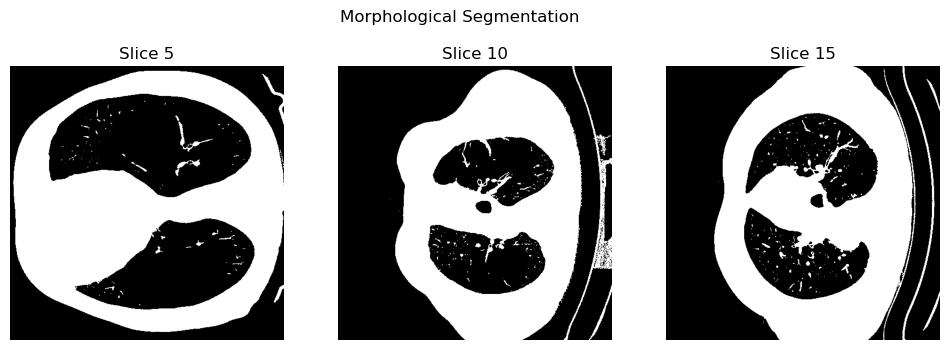

In [11]:
# Windowing for air vs. tissue (-1000 to -400 HU) for initial binary segmentation
lung_window_morph = np.clip(lung_volume, -1000, -400)
binary_morph_volume = lung_window_morph > -600

# Apply morphological operations to clean up the mask
morph_volume = morphology.remove_small_objects(binary_morph_volume.astype(bool), min_size=500)
morph_volume = ndi.binary_fill_holes(morph_volume)

# Visualize morphological segmentation
plot_slices(morph_volume, "Morphological Segmentation")


#### 5. Texture-Based Segmentation: Local Binary Patterns (LBP)

**Texture-Based Segmentation using Local Binary Patterns (LBP)** is a technique that focuses on analyzing the texture features of an image to segment different regions based on their local patterns. LBP is a simple yet powerful descriptor that encodes the local texture information by comparing the intensity of a pixel with its neighboring pixels.

##### Key Features:
- **Local Texture Analysis**: LBP converts an image into a binary representation by comparing each pixel to its neighbors, resulting in a unique binary code that reflects local texture characteristics.
- **Robustness to Illumination Changes**: This method is particularly effective in varying lighting conditions, as it focuses on the relative differences between pixel intensities rather than their absolute values.
- **Applications**: Commonly used in facial recognition, object detection, and medical imaging to distinguish between different tissue types or abnormalities based on their texture.

Texture-based segmentation using LBP is especially useful when the image contains distinct textural patterns that can help differentiate between regions.

In this code, we perform texture-based segmentation using Local Binary Patterns to analyze and categorize different regions of the image based on their texture features. The segmented result is saved and visualized, demonstrating the effectiveness of LBP in capturing and distinguishing textural variations.

/home/lechaudepierre/miniconda3/envs/new_env/lib/python3.12/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


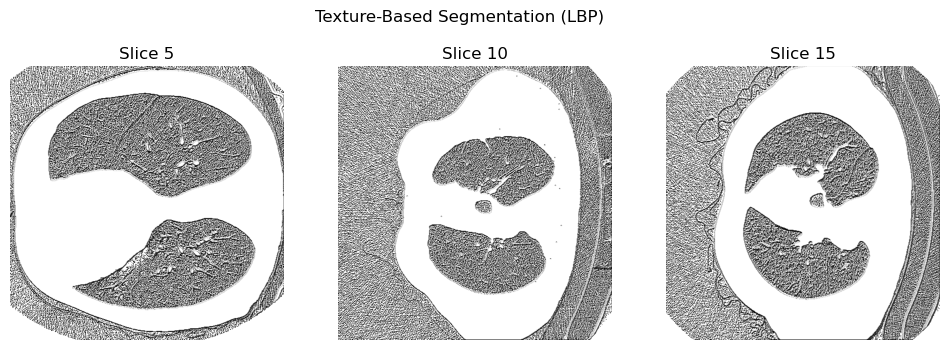

In [12]:
# Windowing for emphasizing lung textures (-1000 to -400 HU)
lung_window_texture = np.clip(lung_volume, -1000, -400)
normalized_lung_texture = (lung_window_texture - lung_window_texture.min()) / (
    lung_window_texture.max() - lung_window_texture.min())

# Apply Local Binary Patterns (LBP) to identify texture patterns
texture_volume = np.zeros_like(normalized_lung_texture)
for i in range(normalized_lung_texture.shape[2]):
    texture_volume[:, :, i] = local_binary_pattern(normalized_lung_texture[:, :, i], P=8, R=1)

# Visualize texture-based segmentation
plot_slices(texture_volume, "Texture-Based Segmentation (LBP)")


#### 6. Statistical Shape Models (SSM)

**Statistical Shape Models (SSM)** are a powerful approach to image segmentation that leverages statistical information about the shapes of objects in an image. This method models the variability of object shapes based on a training set, enabling accurate segmentation by comparing the observed shape with the learned statistical models.

##### Key Features:
- **Shape Variability**: SSM captures the mean shape and its variations from a set of training examples, allowing for the modeling of both common and atypical shapes.
- **Shape Constraints**: Incorporates prior knowledge about the expected shapes, guiding the segmentation process to favor plausible shapes based on the statistical model.
- **Applications**: Widely used in medical imaging to segment anatomical structures, such as organs or lesions, where shape information is critical for accurate delineation.

Statistical Shape Models are particularly effective when segmenting objects with consistent shapes, as they enhance the robustness of the segmentation against noise and variations.

In this code, we perform segmentation using Statistical Shape Models to delineate objects in the image based on learned shape characteristics. The segmented result is saved and visualized, showcasing the effectiveness of SSM in accurately capturing object shapes.

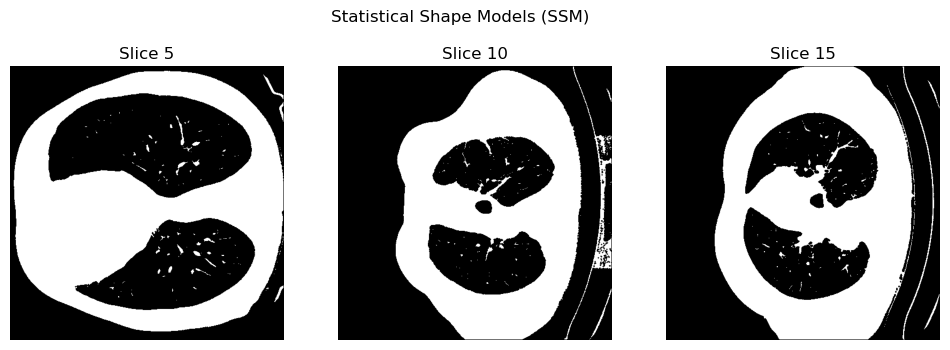

In [13]:
# Use a 2D disk-shaped structuring element for each slice
shape_mask = morphology.disk(1)  # Create a 2D disk-shaped structure
ssm_volume = np.zeros_like(lung_volume)

for i in range(lung_volume.shape[2]):
    ssm_volume[:, :, i] = ndi.binary_erosion(binary_volume[:, :, i], structure=shape_mask)

# Visualize Statistical Shape Model-based segmentation
plot_slices(ssm_volume, "Statistical Shape Models (SSM)")


In [14]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def plot_3d(image, threshold=-300, title="3D Visualization"):
    """
    Generates a 3D plot for the given 3D image volume using a specified threshold.
    :param image: 3D numpy array representing the volume to visualize.
    :param threshold: Threshold for the `marching_cubes` algorithm.
    :param title: Title for the plot.
    """
    # Reorient the image so it is displayed correctly in 3D space.
    p = image.transpose(2, 1, 0)
    
    # Extract mesh using marching cubes at the given threshold.
    verts, faces, _, _ = measure.marching_cubes(p, level=threshold)

    # Create a figure for 3D plotting.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Create a 3D mesh collection.
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    face_color = [0.45, 0.45, 0.75]  # Adjust color for better visualization.
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    # Set limits to match the volume's dimensions.
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.title(title)
    plt.show()


In [15]:
from skimage.transform import resize

# Downsample the lung volume for faster rendering
downsampled_volume = resize(lung_volume, (lung_volume.shape[0]//2, lung_volume.shape[1]//2, lung_volume.shape[2]//2),
                            mode='constant', anti_aliasing=True)

# Visualize the downsampled volume with a suitable threshold
plot_3d(downsampled_volume, threshold=-700, title="3D Visualization of Downsampled Lung CT")


KeyboardInterrupt: 

In [ ]:
# Visualize the region-based segmentation (watershed) in 3D
plot_3d(watershed_volume, threshold=0.5, title="3D Visualization of Region-Based Segmentation (Watershed)")


In [ ]:
# Visualize the edge-based segmentation in 3D
plot_3d(edge_volume, threshold=0.5, title="3D Visualization of Edge-Based Segmentation (Canny)")


In [ ]:
# Visualize the graph-based segmentation in 3D
plot_3d(graph_volume, threshold=0.5, title="3D Visualization of Graph-Based Segmentation (Random Walker)")


In [ ]:
# Visualize the morphological segmentation in 3D
plot_3d(morph_volume, threshold=0.5, title="3D Visualization of Morphological Segmentation")


In [ ]:
# Visualize the texture-based segmentation in 3D
plot_3d(texture_volume, threshold=0.5, title="3D Visualization of Texture-Based Segmentation")


In [ ]:
# Visualize the level set segmentation (GAC) in 3D
plot_3d(gac_volume, threshold=0.5, title="3D Visualization of Level Set Segmentation (GAC)")


### Metrics Overview

When comparing different segmentation methods, especially in the context of medical image segmentation, it's crucial to evaluate their performance using a variety of metrics that quantify accuracy and quality. Below are commonly used metrics for assessing segmentation methods:

1. **Dice Similarity Coefficient (DSC)**:
   - Measures the overlap between the predicted segmentation and the ground truth.
   - Ranges from **0** (no overlap) to **1** (perfect overlap).
   - **Formula**: 
     $$
     \text{DSC} = \frac{2 \times |A \cap B|}{|A| + |B|}
     $$
   - Where \( A \) is the predicted segmentation and \( B \) is the ground truth.
   - **Interpretation**: Higher DSC values indicate better overlap between the predicted segmentation and the ground truth, reflecting higher accuracy.

2. **Jaccard Index (Intersection over Union, IoU)**:
   - Similar to DSC, this metric measures the ratio of the intersection to the union of the predicted and ground truth segmentations.
   - Ranges from **0** (no overlap) to **1** (perfect overlap).
   - **Formula**:
     $$
     \text{IoU} = \frac{|A \cap B|}{|A \cup B|}
     $$
   - **Interpretation**: Like the DSC, higher IoU values signify better segmentation performance, with values closer to 1 indicating that the predicted segmentation closely matches the ground truth.

3. **Hausdorff Distance (HD)**:
   - Measures the maximum distance between points in the predicted segmentation boundary and the ground truth.
   - This metric provides insight into the largest segmentation error.
   - **Interpretation**: Lower HD values indicate better segmentation accuracy, as they reflect smaller maximum errors between the predicted and actual boundaries.

4. **Mean Surface Distance (MSD)**:
   - Measures the average distance between the surfaces of the predicted and ground truth segmentations.
   - Useful for assessing boundary accuracy.
   - **Interpretation**: Lower MSD values indicate better alignment between the predicted segmentation and the ground truth, highlighting effective boundary delineation.

These metrics provide a comprehensive evaluation of segmentation performance, allowing for informed comparisons between different methods based on their ability to accurately delineate anatomical structures in medical images.

### ### Coding project - **Skull Stripping of Brain MRI**

**Objective:**  
Perform skull stripping on brain MRI (brain.nii from previous TP) to isolate the brain tissue from surrounding structures, such as the skull and scalp. The goal is to achieve accurate segmentation of brain tissue and evaluate the quality of the segmentation using appropriate metrics.

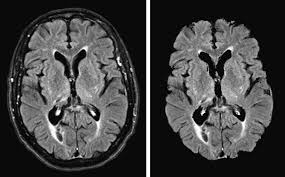

1. **Skull Stripping Techniques:**  
   - Implement various skull stripping methods to segment the brain from non-brain structures. Focus on techniques that effectively handle the complexities of MRI data, such as intensity variations and anatomical differences.

2. **Evaluate Segmentation Quality:**  
   - Calculate the following similarity metrics to assess the quality of the brain segmentation:
     - **Dice Similarity Coefficient (DSC)**
     - **Jaccard Index (IoU)**
     - **Mean Surface Distance (MSD)**

3. **Analysis and Comparison:**  
   - Compare the similarity metrics obtained from different skull stripping methods.
   - Analyze which method provides the most accurate segmentation of brain tissue based on the calculated metrics.

##### Considerations for Skull Stripping of Brain MRI:

- **Intensity Variability:**  
  MRI images can exhibit variability in intensity due to noise, artifacts, and differences in scanning protocols. Employing robust methods that can adapt to these variations is essential for accurate segmentation.

- **Anatomical Variability:**  
  Each individual's brain anatomy may differ significantly, necessitating the use of techniques that can generalize well across different brain shapes and sizes.

- **Preprocessing Needs:**  
  Resampling the MRI images to a uniform resolution and normalizing intensity values can improve segmentation accuracy. Optionally, applying filtering techniques can enhance image quality before skull stripping.

- **Boundary Definition:**  
  The boundaries between brain tissue and surrounding structures may be blurred; thus, methods that effectively handle smooth transitions and maintain the integrity of the brain’s shape should be prioritized.

- **Impact on Metrics:**  
  Metrics like **DSC** and **IoU** provide valuable insights into segmentation accuracy, while **MSD** can help assess boundary alignment. Visual assessments alongside these metrics can validate the segmentation results.

This task is crucial for subsequent neuroimaging analyses, ensuring that accurate brain segmentation lays the foundation for reliable results in various medical applications.

# Metrics and plot_slice
here we made the functions for the differents metrics overview and we redefine the plo_slice function. 

In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from skimage import morphology

from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, remove_small_holes, binary_opening, binary_closing, disk
from skimage.segmentation import watershed
from skimage.feature import canny
from skimage.measure import label, regionprops, marching_cubes
from skimage.metrics import hausdorff_distance
from sklearn.metrics import jaccard_score


def dice_coefficient(pred_mask, true_mask):
   
    pred_bin = pred_mask.astype(bool)
    true_bin = true_mask.astype(bool)
    intersection = np.logical_and(pred_bin, true_bin).sum()
    return 2.0 * intersection / (pred_bin.sum() + true_bin.sum() + 1e-8)

def iou_coefficient(pred_mask, true_mask):
   
    pred_bin = pred_mask.astype(bool)
    true_bin = true_mask.astype(bool)
    intersection = np.logical_and(pred_bin, true_bin).sum()
    union = np.logical_or(pred_bin, true_bin).sum()
    return intersection / (union + 1e-8)

def mean_surface_distance(pred_mask, true_mask):
    
    from scipy.spatial import cKDTree

    # Convert to binary & find boundary coordinates
    pred_bin = pred_mask.astype(bool)
    true_bin = true_mask.astype(bool)

    # Identify boundary using binary_dilation XOR original => boundary points
    pred_boundary = np.logical_xor(pred_bin, ndi.binary_dilation(pred_bin))
    true_boundary = np.logical_xor(true_bin, ndi.binary_dilation(true_bin))

    pred_pts = np.argwhere(pred_boundary)  # shape [N, 3] or [N,2] if 2D
    true_pts = np.argwhere(true_boundary)

    if len(pred_pts) == 0 or len(true_pts) == 0:
        return np.nan  # or 0 if one mask has no boundary

    # Build KD-tree for fast nearest-neighbor lookup
    pred_kdtree = cKDTree(pred_pts)
    true_kdtree = cKDTree(true_pts)

    # Distances from pred boundary -> true boundary
    dists1, _ = pred_kdtree.query(true_pts)
    # Distances from true boundary -> pred boundary
    dists2, _ = true_kdtree.query(pred_pts)

    # Average them
    msd_value = (dists1.mean() + dists2.mean()) / 2.0
    return msd_value


def plot_slices(volume, slices=None, title=""):
    """
    Plots a few slices from a 3D volume (assuming shape [X, Y, Z]).
    If slices not given, pick middle slices.
    """
    if slices is None:
        z_mid = volume.shape[2] // 2
        slices = [z_mid-5, z_mid, z_mid+5]

    fig, axes = plt.subplots(1, len(slices), figsize=(15, 5))
    for ax, idx in zip(axes, slices):
        ax.imshow(volume[:, :, idx], cmap='gray')
        ax.set_title(f"{title} (slice={idx})")
        ax.axis('off')
    plt.show()


def plot_slices(volume, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    mid_slices = [150, 300, 400]  # Adjust based on volume size
    for ax, slice_idx in zip(axes, mid_slices):
        ax.imshow(volume[:, :, slice_idx], cmap='gray')
        ax.set_title(f'Slice {slice_idx}')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()


Load the brain scan file 

Brain MRI shape: (489, 734, 503)


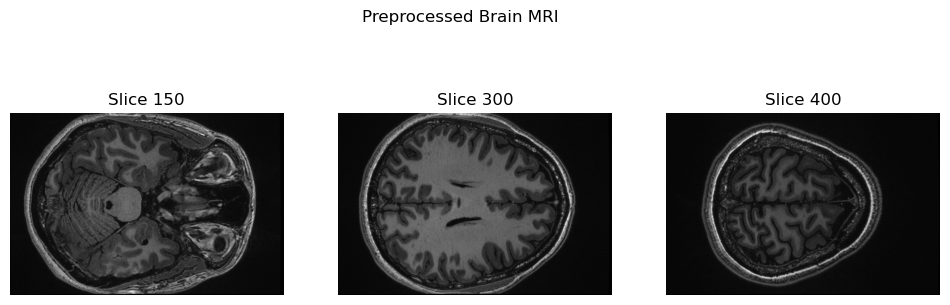

In [3]:
brain_vol_nii = nib.load('../TP4-Understanding/brain1.nii')
brain_data = brain_vol_nii.get_fdata()
print("Brain MRI shape:", brain_data.shape)


# Simple intensity normalization
brain_data_norm = (brain_data - np.min(brain_data)) / (np.max(brain_data) - np.min(brain_data) + 1e-8)

# Optionally apply a small Gaussian filter or median to reduce noise
# from scipy.ndimage import gaussian_filter
# brain_data_preproc = gaussian_filter(brain_data_norm, sigma=1.0)
brain_data_preproc = brain_data_norm  # no smoothing for now

plot_slices(brain_data_preproc, title="Preprocessed Brain MRI")


# treshold based

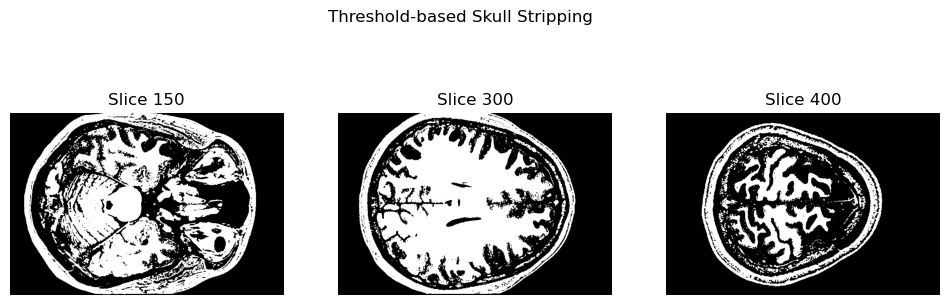

In [4]:
# Apply windowing: focus on typical lung tissue range in Hounsfield Units (HU)
# This range is typically between -1000 and -400 HU for lung tissues.


# Normalize the windowed volume to [0, 1] for better thresholding
#normalized_brain_volume = (brain_window - brain_window.min()) / (brain_window.max() - brain_window.min())
threshold_val = threshold_otsu(brain_data_preproc)
brain_threshold_mask = (brain_data_preproc > threshold_val)

plot_slices(brain_threshold_mask, title="Threshold-based Skull Stripping")


# Morphologiacal based

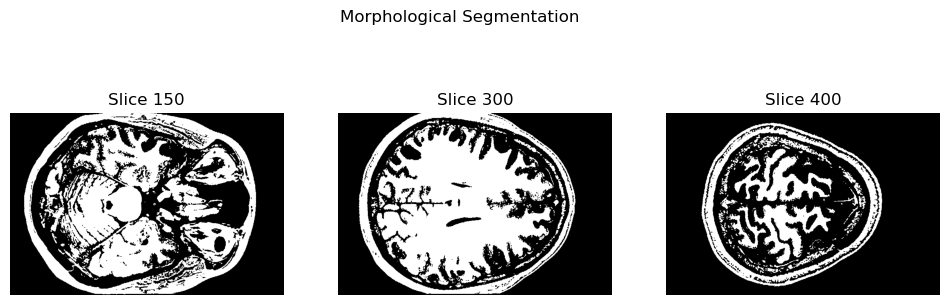

In [5]:
#windowed_brain_morph = np.clip(brain_data, -1000, -400)
binary_morph_brain_volume = brain_data_preproc > threshold_val

# Apply morphological operations to clean up the mask
morph_volume = morphology.remove_small_objects(binary_morph_brain_volume.astype(bool), min_size=500)
morph_volume = ndi.binary_fill_holes(morph_volume)

# Visualize morphological segmentation
plot_slices(morph_volume, "Morphological Segmentation")


# edge based 

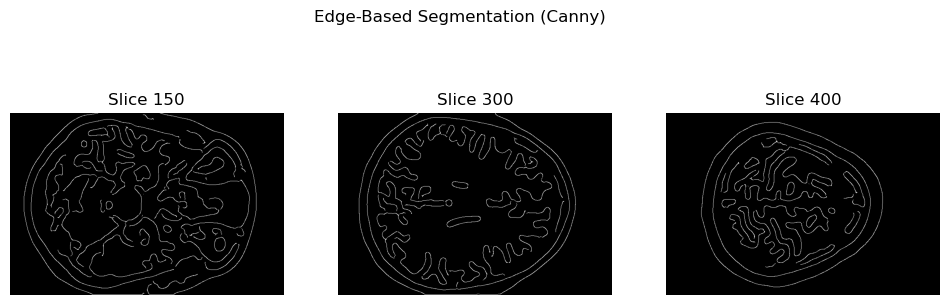

In [27]:
# Apply Canny edge detection on each slice
edge_volume = np.zeros_like(binary_morph_brain_volume)
for i in range(binary_morph_brain_volume.shape[2]):
    edge_volume[:, :, i] = canny(binary_morph_brain_volume[:, :, i], sigma=7)

# Visualize edge-based segmentation
plot_slices(edge_volume, "Edge-Based Segmentation (Canny)")

# region based (watershed) 

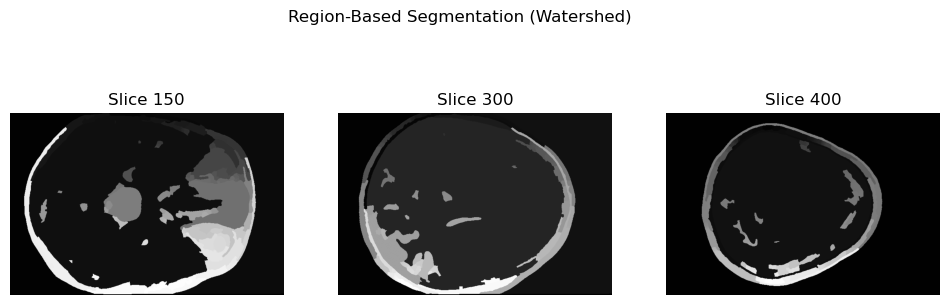

In [32]:
# Use Canny edge detection as markers for watershed
watershed_volume = np.zeros_like(brain_data)
for i in range(brain_data_norm.shape[2]):
    edges = canny(brain_data_norm[:, :, i], sigma= 2)
    distance = ndi.distance_transform_edt(~edges)
    markers = ndi.label(distance > 5)[0]
    watershed_slice = watershed(-distance, markers, mask=brain_data[:, :, i])
    watershed_volume[:, :, i] = watershed_slice

# Visualize region-based segmentation
plot_slices(watershed_volume, "Region-Based Segmentation (Watershed)")

it seems not to work so well, maybe because the brain is to textured and thus it's difficults to recognize a real form. 